In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

In [2]:
from utils import show_prompt
from cad_agent_from_scratch.prompts import PLAN_DESIGN_INTENT_PROMPT
show_prompt(PLAN_DESIGN_INTENT_PROMPT, "Plan Design Intent Prompt")

╭─────────────────────────────────────────── Plan Design Intent Prompt ───────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  You are a CAD Planning Agent.                                                                                  │
│                                                                                                                 │
│  You are given a FINALIZED CAD design intent and its structured interpretation.                                 │
│  Your task is to produce a HIGH-LEVEL CAD DESIGN PLAN that will be reviewed and                                 │
│  approved by a human BEFORE any CAD code is written.                                                            │
│                                                                                                                 │
│  You are NOT designing geometry.                                                                                │
│  You are NOT inventing structure.                                                                               │
│  You are articulating a clear plan based strictly on the clarified intent.                                      │
│                                                                                                                 │
│  --------------------------------------------------                                                             │
│  INPUT CONTEXT                                                                                                  │
│  --------------------------------------------------                                                             │
│                                                                                                                 │
│  Finalized Design Intent (human-readable):                                                                      │
│  <DesignIntent>                                                                                                 │
│  {design_intent}                                                                                                │
│  </DesignIntent>                                                                                                │
│                                                                                                                 │
│  Parsed Design Intent (structured, explicit facts only):                                                        │
│  <ParsedIntent>                                                                                                 │
│  {parsed_intent}                                                                                                │
│  </ParsedIntent>                                                                                                │
│                                                                                                                 │
│  Human Feedback (if any, from previous review):                                                                 │
│  <HumanFeedback>                                                                                                │
│  {human_feedback}                                                                                               │
│  </HumanFeedback>                                                                                               │
│                                                                                                                 │
│  If HumanFeedback is "None", generate the initial plan.                                                         │
│  If HumanFeedback is present, revise the plan ONLY to address that feedback,                                    │
│  without introducing new components or assumptions.   

In [3]:
%%writefile ../src/cad_agent_from_scratch/design_planning_state.py

"""
TypedDict-based state for the CAD Planning sub-agent.

This is an INTERNAL agent state (like research_agent.py),
NOT a LangGraph MessagesState.
"""

from typing_extensions import TypedDict, Annotated, Sequence, Optional
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class PlanningAgentState(TypedDict):
    # Inputs (copied from shared state)
    design_intent: str
    parsed_intent: dict

    # Planning loop
    planner_messages: Annotated[Sequence[BaseMessage], add_messages]
    human_feedback: Optional[str]
    iterations: int

    # Output
    design_plan: Optional[str]


Overwriting ../src/cad_agent_from_scratch/design_planning_state.py


In [4]:
%%writefile ../src/cad_agent_from_scratch/design_planning_workflow.py

"""
CAD Planning Sub-Agent (TypedDict-based).

Mirrors deep_research/research_agent.py exactly.
"""

from pydantic import BaseModel, Field

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.types import interrupt

from cad_agent_from_scratch.prompts import PLAN_DESIGN_INTENT_PROMPT
from cad_agent_from_scratch.design_planning_state import PlanningAgentState


# ---------------- MODEL ---------------- #

model = init_chat_model(
    model="gpt-4.1-mini",
    temperature=0.0,
)


# ---------------- SCHEMA ---------------- #

class PlanDesignIntent(BaseModel):
    design_plan: str = Field(...)
    ready_for_review: bool = Field(...)


# ---------------- NODES ---------------- #

def generate_plan(state: PlanningAgentState):
    # Safety guard against infinite loops
    if state.get("iterations", 0) >= 5:
        return END

    structured_model = model.with_structured_output(PlanDesignIntent)

    prompt = PLAN_DESIGN_INTENT_PROMPT.format(
        design_intent=state["design_intent"],
        parsed_intent=state["parsed_intent"],
        human_feedback=state.get("human_feedback") or "None",
    )

    response = structured_model.invoke(
        [HumanMessage(content=prompt)]
    )

    return {
        "design_plan": response.design_plan,
        "planner_messages": [AIMessage(content=response.design_plan)],
        "iterations": state.get("iterations", 0) + 1,
    }


def hitl_review(state: PlanningAgentState):
    request = {
        "action_request": {
            "action": "Review CAD Design Plan",
            "args": {},
        },
        "config": {
            "allow_accept": True,
            "allow_edit": True,
            "allow_ignore": True,
        },
        "description": state["design_plan"],
    }

    result = interrupt([request])[0]

    if result["type"] == "accept":
        return END

    if result["type"] == "edit":
        return {
            "human_feedback": result["args"],
        }

    return END


# ---------------- GRAPH ---------------- #

planning_builder = StateGraph(PlanningAgentState)

planning_builder.add_node("generate_plan", generate_plan)
planning_builder.add_node("hitl_review", hitl_review)

planning_builder.add_edge(START, "generate_plan")
planning_builder.add_edge("generate_plan", "hitl_review")
planning_builder.add_edge("hitl_review", "generate_plan")

planning_agent = planning_builder.compile()


Overwriting ../src/cad_agent_from_scratch/design_planning_workflow.py


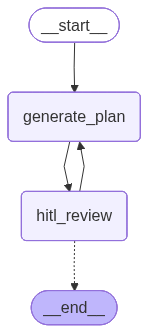

In [11]:
from langgraph.checkpoint.memory import InMemorySaver
from cad_agent_from_scratch.design_planning_workflow import planning_builder
from IPython.display import Image, display

checkpointer = InMemorySaver()

planning_agent = planning_builder.compile(
    checkpointer=checkpointer
)

display(
    Image(planning_agent.get_graph(xray=True).draw_mermaid_png())
)


In [16]:
thread = {"configurable": {"thread_id": "15"}}

state = {
    "design_intent": "Design a solid cube with a side length of 50 units.",
    "parsed_intent": {
        "object_name": "cube",
        "components": ["cube"],
        "dimensions": {"side_length": "50 units"},
        "configuration": "solid",
        "assumptions": None,
    },
    "planner_messages": [],
    "human_feedback": None,
}

for chunk in planning_agent.stream(state, config=thread):
    if "__interrupt__" in chunk:
        interrupt_obj = chunk["__interrupt__"][0]

        print("🔴 HUMAN REVIEW REQUIRED")

        # ✅ interrupt.value is a LIST → take first element
        request = interrupt_obj.value[0]

        print(request["description"])

    else:
        print(chunk)

{'generate_plan': {'design_plan': '1. Single solid cubic body forming the entire object.\n2. All faces are equal in size, defining a uniform cube.\n3. Each edge has an approximate length of 50 units.\n4. The object is static with no internal cavities or additional features.\n\nDoes this plan look good to proceed with CAD modeling?', 'planner_messages': [AIMessage(content='1. Single solid cubic body forming the entire object.\n2. All faces are equal in size, defining a uniform cube.\n3. Each edge has an approximate length of 50 units.\n4. The object is static with no internal cavities or additional features.\n\nDoes this plan look good to proceed with CAD modeling?', additional_kwargs={}, response_metadata={}, id='f68b34b5-5b0b-45a1-9a8d-5657fb81b674')], 'iterations': 1}}
🔴 HUMAN REVIEW REQUIRED
1. Single solid cubic body forming the entire object.
2. All faces are equal in size, defining a uniform cube.
3. Each edge has an approximate length of 50 units.
4. The object is static with no

In [17]:
result = planning_agent.invoke(
    Command(
        resume={
            "type": "accept"
        }
    ),
    config=thread
)

print("✅ Plan approved")
print(result["design_plan"])


KeyError: 0

In [18]:
from langgraph.types import Command

result = planning_agent.invoke(
    Command(
        resume={
            "type": "edit",
            "args": "Make the cube hollow instead of solid"
        }
    ),
    config=thread
)

print("🔁 Revised plan:")
print(result["design_plan"])

KeyError: 0

# Run the CAD design planning workflow
from utils import format_messages
# from cad_agent_from_scratch.design_planning_workflow import builder

thread = {"configurable": {"thread_id": "11"}}

for chunk in scope.stream(
    {
        "design_intent": "Design a solid cube with a side length of 50 units.",
        "parsed_intent": {
            "object_name": "cube",
            "components": ["cube"],
            "dimensions": {"side_length": "50 units"},
            "configuration": "solid",
            "assumptions": None,
        },
    },
    config=thread,
):
    # Inspect interrupt
    if "__interrupt__" in chunk:
        interrupt_obj = chunk["__interrupt__"][0]
        print("INTERRUPTED FOR HUMAN REVIEW")
        print(interrupt_obj["value"]["description"])



result["design_plan"]